In [1]:
# Import packages
import warnings # This suppresses some meaningless errors from Seaborn and Pandas
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from urllib.request import urlopen
from requests import get
from urllib.parse import urlparse
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import probplot
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# If you has the file"analysis_dataframe.parquet", pls start from data analysis part

# Preprocessing Data

In [3]:
# files saved under dataset
dir = 'dataset/'
# raw files
attendent_raw ='jan-dec-2022-gla-data-extract-attendant.csv'
# casualities_raw ='jan-dec-2022-gla-data-extract-casualties.csv'
vehicle_raw ='jan-dec-2022-gla-data-extract-vehicle.csv'
# cycle lane and track
cycle_lane= 'cycle_lane_track.json'

# saved file name
collision_counts_fn = 'collision_counts.geoparquet'

# using Vehicle dataset as the primary  dataset
# check if gpkg file already exists
# if not, convert the raw file into geoparquet after reading it in
if not os.path.exists(os.path.join(dir, collision_counts_fn)):
    print("Loading collision counts from csv and saving as geoparquet")
    collision_df = pd.read_csv(os.path.join(dir, vehicle_raw))
    collision_gdf = gpd.GeoDataFrame(collision_df, geometry = gpd.points_from_xy(collision_df['Easting'], collision_df['Northing'], crs = 'EPSG:27700'))
    # saved the file
    collision_gdf.to_parquet(os.path.join(dir, collision_counts_fn))

# if file already there, load from gpkg
else:
    print("Loading locations from processed geoparquet")
    collision_gdf = gpd.read_parquet(os.path.join(dir, collision_counts_fn))

print("Location load complete. Use collision_gdf")

# load other datasests
attendent_df = pd.read_csv(os.path.join(dir, attendent_raw))
# casualties_df = pd.read_csv(os.path.join(dir, casualities_raw))

# Load GeoJSON file into GeoDataFrame
cycle_lane_gdf = gpd.read_file(os.path.join(dir,cycle_lane))
cycle_lane_gdf.to_crs(epsg=27700, inplace=True)
cycle_lane_gdf = cycle_lane_gdf[['FEATURE_ID', 'CLT_CARR', 'CLT_SEGREG', 'CLT_SHARED', 'CLT_PRIORI', 'BOROUGH','geometry']]

Loading collision counts from csv and saving as geoparquet
Location load complete. Use collision_gdf


In [4]:
# london borough
London_boro = 'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
boro_gdf = gpd.read_file(os.path.join(dir, London_boro))

In [5]:
# Select the variables
# index: 
# collision_df: '_Collision Id'
# location  and london borough:
# collision_df: 'Borough Name', 'Borough Number','Easting','Northing'

# Dependent variable: the degree of collision severity (fatal, slight and serious)
# attendent_df: '_Collision Severity'

# Independent variable
# 1. driver characteristics: Gender Age
# collision_df: 'Driver Gender','Driver Age','Driver age (Banded)'
selected_collision= ['_Collision Id','Borough Name', 'Borough Number','Easting','Northing','Vehicle Type Banded', 'Vehicle Type','Driver Gender','Driver Age','Driver age (Banded)']
sub_collision_df = collision_df [selected_collision] 
# 2. Road characteristocs: 'First Road Class','Road Type','Speed Limit'
# 3. Collision conditions :'Light Conditions','Weather Details','Road Surface Condition'

# attendent variable:'Collision Severity', 'First Road Class','Road Type','Speed Limit','Light Conditions','Weather Details','Road Surface Condition'
selected_attendent = ['_Collision Id', '_Collision Severity', 'First Road Class','Road Type','Speed Limit','Light Conditions','Weather Details','Road Surface Condition']
selected_attendent_df = attendent_df[selected_attendent]
# merge the variables
total_collision_df = pd.merge(sub_collision_df,selected_attendent_df, on='_Collision Id', how='left')

In [6]:
# 4. Collision category; The typed of collision
#4-1. increased the column to know the involved vehicles for each collision number
grouped_collision_df = total_collision_df.groupby('_Collision Id')['Vehicle Type Banded'].agg(involved_vehicles=lambda x: sorted(list(x))).reset_index()
# add the involved_vehicles to collision_gdf 
total_collision_df = pd.merge(grouped_collision_df, total_collision_df, on='_Collision Id', how='left')
#select the collision with Pedal Cycle
cycle_df = total_collision_df[total_collision_df['Vehicle Type'] == 'Pedal Cycle']

In [7]:
#5. cycle lane category; The types of collision
cycle_gdf = gpd.GeoDataFrame(cycle_df,geometry = gpd.points_from_xy(cycle_df['Easting'], cycle_df['Northing'], crs = 'EPSG:27700'))

In [8]:
print(cycle_gdf.crs)

EPSG:27700


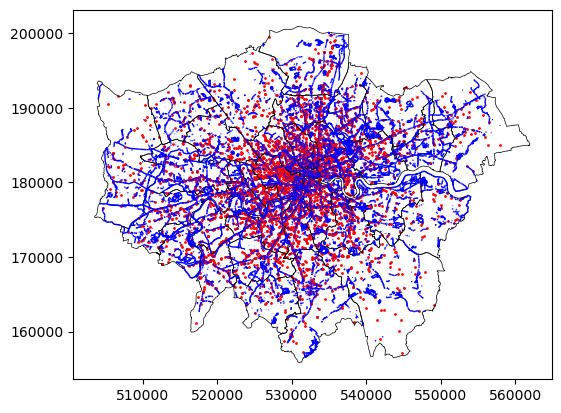

In [9]:
# Plot lines
ax = cycle_lane_gdf.plot(color='blue', linewidth=1)

# Plot points on the same axes
cycle_gdf.plot(ax=ax, color='red', markersize=1)

# Add London boroughs map as a base map
boro_gdf.plot(ax=ax, color='none', edgecolor='black',linewidth=0.5) 
# Show the plot
plt.show()

/tmp/ipykernel_3618/3786174759.py:9: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


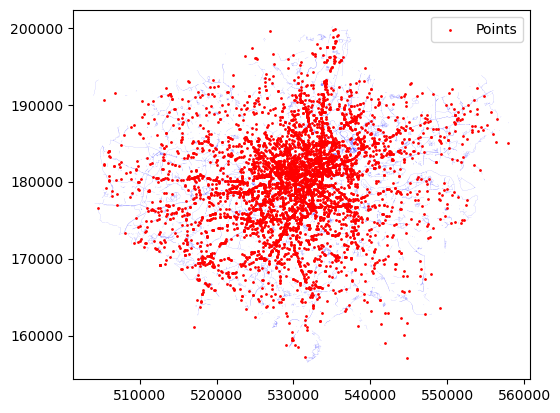

In [10]:
# Create a buffer around the lines
buffer_distance = 5  # Adjust the buffer distance as needed
cycle_lane_gdf['buffer'] = cycle_lane_gdf['geometry'].buffer(buffer_distance)

# Plot the lines and their buffers
ax = cycle_lane_gdf['buffer'].plot( color='blue', label='Buffers')
cycle_gdf.plot(ax=ax, color='red', label='Points', markersize=1)
# Add legend
ax.legend()

# zoom in the map
#x_min= 539250
#x_max = 540000
#y_min = 178000
#y_max = 178500
#plt.xlim(x_min, x_max)  
#plt.ylim(y_min, y_max) 
plt.show()

In [11]:
poly_cycle_lane_gdf = cycle_lane_gdf.drop('geometry', axis=1)
poly_cycle_lane_gdf = poly_cycle_lane_gdf.set_geometry('buffer')

In [12]:
cycle_gdf = cycle_gdf.reset_index(drop=True)

In [13]:
# Perform spatial join
total_dataset = gpd.sjoin(cycle_gdf, poly_cycle_lane_gdf, how='left', op='intersects')

# Create a new column with binary variables
total_dataset['intersection'] = total_dataset['index_right'].notna()

total_dataset

,_Collision Id,involved_vehicles,Borough Name,Borough Number,Easting,Northing,Vehicle Type Banded,Vehicle Type,Driver Gender,Driver Age,...,Road Surface Condition,geometry,index_right,FEATURE_ID,CLT_CARR,CLT_SEGREG,CLT_SHARED,CLT_PRIORI,BOROUGH,intersection
0,1220352601,[Pedal Cycle],Hackney,4,532694,183413,Pedal Cycle,Pedal Cycle,Male,41.0,...,Road-Dry,POINT (532694.000 183413.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1220352612,"[Car, Pedal Cycle]",Haringey,31,528471,189140,Pedal Cycle,Pedal Cycle,Male,64.0,...,Road-Dry,POINT (528471.000 189140.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,1220352651,"[Car, Pedal Cycle]",Tower Hamlets,5,534715,182691,Pedal Cycle,Pedal Cycle,Male,23.0,...,Road-Dry,POINT (534715.000 182691.000),21059.0,RWG073306,TRUE,FALSE,TRUE,FALSE,Tower Hamlets,True
3,1220352661,"[Car, Pedal Cycle]",Brent,28,522942,183195,Pedal Cycle,Pedal Cycle,Male,59.0,...,Road-Wet,POINT (522942.000 183195.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,1220352702,"[Car, Pedal Cycle]",Enfield,32,532532,194267,Pedal Cycle,Pedal Cycle,Male,71.0,...,Road-Dry,POINT (532532.000 194267.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,48221291919,"[Pedal Cycle, Taxi]",City Of London,0,532016,181806,Pedal Cycle,Pedal Cycle,Female,29.0,...,Road-Dry,POINT (532016.000 181806.000),16370.0,RWG066465,TRUE,FALSE,FALSE,FALSE,City of London,True
5404,48221292373,"[Pedal Cycle, Taxi]",City Of London,0,532976,180959,Pedal Cycle,Pedal Cycle,Male,46.0,...,Road-Dry,POINT (532976.000 180959.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5405,48221292397,"[Pedal Cycle, Taxi]",City Of London,0,533151,181140,Pedal Cycle,Pedal Cycle,Male,39.0,...,Road-Frost/Ice,POINT (533151.000 181140.000),16926.0,RWG066156,TRUE,FALSE,FALSE,FALSE,City of London,True
5406,48221292410,"[Pedal Cycle, Pedal Cycle]",City Of London,0,532553,180786,Pedal Cycle,Pedal Cycle,Male,25.0,...,Road-Dry,POINT (532553.000 180786.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [14]:
# Check for duplicate connections
duplicates = total_dataset.index.duplicated()
# Filter out duplicate rows
duplicate_rows = total_dataset[duplicates]
# If duplicates exist, delete the duplicate rows 
if duplicates.any():
    total_dataset = total_dataset[~duplicates]
total_dataset

,_Collision Id,involved_vehicles,Borough Name,Borough Number,Easting,Northing,Vehicle Type Banded,Vehicle Type,Driver Gender,Driver Age,...,Road Surface Condition,geometry,index_right,FEATURE_ID,CLT_CARR,CLT_SEGREG,CLT_SHARED,CLT_PRIORI,BOROUGH,intersection
0,1220352601,[Pedal Cycle],Hackney,4,532694,183413,Pedal Cycle,Pedal Cycle,Male,41.0,...,Road-Dry,POINT (532694.000 183413.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1220352612,"[Car, Pedal Cycle]",Haringey,31,528471,189140,Pedal Cycle,Pedal Cycle,Male,64.0,...,Road-Dry,POINT (528471.000 189140.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,1220352651,"[Car, Pedal Cycle]",Tower Hamlets,5,534715,182691,Pedal Cycle,Pedal Cycle,Male,23.0,...,Road-Dry,POINT (534715.000 182691.000),21059.0,RWG073306,TRUE,FALSE,TRUE,FALSE,Tower Hamlets,True
3,1220352661,"[Car, Pedal Cycle]",Brent,28,522942,183195,Pedal Cycle,Pedal Cycle,Male,59.0,...,Road-Wet,POINT (522942.000 183195.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,1220352702,"[Car, Pedal Cycle]",Enfield,32,532532,194267,Pedal Cycle,Pedal Cycle,Male,71.0,...,Road-Dry,POINT (532532.000 194267.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,48221291919,"[Pedal Cycle, Taxi]",City Of London,0,532016,181806,Pedal Cycle,Pedal Cycle,Female,29.0,...,Road-Dry,POINT (532016.000 181806.000),16370.0,RWG066465,TRUE,FALSE,FALSE,FALSE,City of London,True
5404,48221292373,"[Pedal Cycle, Taxi]",City Of London,0,532976,180959,Pedal Cycle,Pedal Cycle,Male,46.0,...,Road-Dry,POINT (532976.000 180959.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
5405,48221292397,"[Pedal Cycle, Taxi]",City Of London,0,533151,181140,Pedal Cycle,Pedal Cycle,Male,39.0,...,Road-Frost/Ice,POINT (533151.000 181140.000),16926.0,RWG066156,TRUE,FALSE,FALSE,FALSE,City of London,True
5406,48221292410,"[Pedal Cycle, Pedal Cycle]",City Of London,0,532553,180786,Pedal Cycle,Pedal Cycle,Male,25.0,...,Road-Dry,POINT (532553.000 180786.000),NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [15]:
# clean the data
# Print the column names
print(total_dataset.columns)

Index(['_Collision Id', 'involved_vehicles', 'Borough Name', 'Borough Number',
       'Easting', 'Northing', 'Vehicle Type Banded', 'Vehicle Type',
       'Driver Gender', 'Driver Age', 'Driver age (Banded)',
       '_Collision Severity', 'First Road Class', 'Road Type', 'Speed Limit',
       'Light Conditions', 'Weather Details', 'Road Surface Condition',
       'geometry', 'index_right', 'FEATURE_ID', 'CLT_CARR', 'CLT_SEGREG',
       'CLT_SHARED', 'CLT_PRIORI', 'BOROUGH', 'intersection'],
      dtype='object')


In [16]:
# clean the Driver age (Banded) with Unknown
total_dataset = total_dataset[total_dataset['Driver age (Banded)'] != 'Unknown']
total_dataset = total_dataset[total_dataset['Driver Gender'] != 'Not Traced']
total_dataset = total_dataset[total_dataset['Road Type'] != 'Unknown']

In [17]:
# create a new dataframe for data analysis
analysis_df= total_dataset [['_Collision Id','Borough Name', 'Borough Number','Easting','Northing','geometry']]

#0. dependent variable
# Collision Severity Slight:1, Serious: 2, Fatal: 3
# ordered variable
analysis_df['serverity']=total_dataset['_Collision Severity'].map({'Slight':0, 'Serious': 1, 'Fatal':2})
# 1.dirver characteristics
# 1-1.Gender 1: Male 0:Female
# binary variable (categorical data) 
analysis_df['gender'] = total_dataset['Driver Gender'].map({'Male': 1,'Female': 0})
# 1-2. Age(banded) 
# 0-16: 1: 1, 17-24:2, 25-34:3, 35-64:4, 65+:5
# binary variable (categorical data) 
analysis_df['age(0-16)'] = total_dataset['Driver age (Banded)'].apply(lambda x: 1 if x == '0-16' else 0)
analysis_df['age(17-24)'] = total_dataset['Driver age (Banded)'].apply(lambda x: 1 if x == '17-24' else 0)
analysis_df['age(25-34)'] = total_dataset['Driver age (Banded)'].apply(lambda x: 1 if x == '25-34' else 0)
analysis_df['age(35-64)'] = total_dataset['Driver age (Banded)'].apply(lambda x: 1 if x == '35-64' else 0)
analysis_df['age(65+)'] = total_dataset['Driver age (Banded)'].apply(lambda x: 1 if x == '65+' else 0)
# 2. Road characteristocs: 'First Road Class','Road Type','Speed Limit'
# 2-1.'First Road Class'
# binary variable (categorical data) 
analysis_df['First Road Class_A'] = total_dataset['First Road Class'].apply(lambda x: 1 if x == 'A' else 0)
analysis_df['First Road Class_B'] = total_dataset['First Road Class'].apply(lambda x: 1 if x == 'B' else 0)
analysis_df['First Road Class_C'] = total_dataset['First Road Class'].apply(lambda x: 1 if x == 'C' else 0)
analysis_df['First Road Class_U'] = total_dataset['First Road Class'].apply(lambda x: 1 if x == 'Unclassified' else 0)
# !!!dummy variable _delete one variable and as a base line!!!

# 2-2.'Road Type'
# binary variable (categorical data) 
analysis_df['RT_Single_Cwy'] = total_dataset['Road Type'].apply(lambda x: 1 if x == 'Single Cwy' else 0)
analysis_df['RT_Dual_Cwy '] = total_dataset['Road Type'].apply(lambda x: 1 if x == 'Dual Cwy' else 0)
analysis_df['RT_One-Way'] = total_dataset['Road Type'].apply(lambda x: 1 if x == 'One-Way St' else 0)
analysis_df['RT_Roundabout'] = total_dataset['Road Type'].apply(lambda x: 1 if x == 'Roundabout' else 0)
analysis_df['RT_Slip Rd'] = total_dataset['Road Type'].apply(lambda x: 1 if x == 'Slip Rd' else 0)
# !!!dummy variable _delete one variable and as a base line!!!

# 2-3.'speed limit'
# continuous variable
analysis_df['speed limit'] = total_dataset['Speed Limit']

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [18]:
#4.cycle lane characteristics
#'having_cycle_lane', have cycle lane: 1, without cycle lane:2
analysis_df['having_cycle_lane'] = total_dataset['intersection'].replace({True: 1, False: 0})

# if it is significant variable of cycle land 
# conduct furthermore analysis
#4.1 'on/off_carriageway'/'Segregated_lanes''Shared_lanes''Priority'
analysis_df['on/off_carriageway'] = total_dataset['CLT_CARR'].map({'TRUE': 1,'FALSE': 0})
analysis_df['Segregated_lanes'] = total_dataset['CLT_SEGREG'].map({'TRUE': 1,'FALSE': 0})
analysis_df['Shared_lanes'] = total_dataset['CLT_SHARED'].map({'TRUE': 1,'FALSE': 0})
analysis_df['Priority'] = total_dataset['CLT_PRIORI'].map({'TRUE': 1,'FALSE': 0})

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [19]:
#check the variable number
a = analysis_df['serverity'].value_counts()
print(a)

serverity
0    3579
1    1055
2       6
Name: count, dtype: int64


In [20]:
# delete the 'fatal' category
analysis_df = analysis_df[analysis_df['serverity'] != 2]
analysis_df
# 4634 columns

,_Collision Id,Borough Name,Borough Number,Easting,Northing,geometry,serverity,gender,age(0-16),age(17-24),...,RT_Dual_Cwy,RT_One-Way,RT_Roundabout,RT_Slip Rd,speed limit,having_cycle_lane,on/off_carriageway,Segregated_lanes,Shared_lanes,Priority
0,1220352601,Hackney,4,532694,183413,POINT (532694.000 183413.000),0,1,0,0,...,1,0,0,0,20,0,NaN,NaN,NaN,NaN
1,1220352612,Haringey,31,528471,189140,POINT (528471.000 189140.000),0,1,0,0,...,0,0,1,0,20,0,NaN,NaN,NaN,NaN
2,1220352651,Tower Hamlets,5,534715,182691,POINT (534715.000 182691.000),0,1,0,1,...,0,0,0,0,30,1,1.0,0.0,1.0,0.0
3,1220352661,Brent,28,522942,183195,POINT (522942.000 183195.000),1,1,0,0,...,0,0,0,0,30,0,NaN,NaN,NaN,NaN
4,1220352702,Enfield,32,532532,194267,POINT (532532.000 194267.000),0,1,0,0,...,0,0,0,0,30,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,48221291919,City Of London,0,532016,181806,POINT (532016.000 181806.000),0,0,0,0,...,0,0,0,0,20,1,1.0,0.0,0.0,0.0
5404,48221292373,City Of London,0,532976,180959,POINT (532976.000 180959.000),0,1,0,0,...,1,0,0,0,20,0,NaN,NaN,NaN,NaN
5405,48221292397,City Of London,0,533151,181140,POINT (533151.000 181140.000),1,1,0,0,...,0,0,0,0,20,1,1.0,0.0,0.0,0.0
5406,48221292410,City Of London,0,532553,180786,POINT (532553.000 180786.000),0,1,0,0,...,0,0,0,0,20,0,NaN,NaN,NaN,NaN


In [21]:
analysis_df.to_parquet(os.path.join(dir, 'analysis_dataframe.parquet'))

# Data Analysis

In [22]:
# files saved under dataset
dir = 'dataset'
analysis_path = 'analysis_dataframe.parquet'

analysis_gdf = gpd.read_parquet(os.path.join(dir, analysis_path))

In [23]:
analysis_gdf

,_Collision Id,Borough Name,Borough Number,Easting,Northing,geometry,serverity,gender,age(0-16),age(17-24),...,RT_Dual_Cwy,RT_One-Way,RT_Roundabout,RT_Slip Rd,speed limit,having_cycle_lane,on/off_carriageway,Segregated_lanes,Shared_lanes,Priority
0,1220352601,Hackney,4,532694,183413,POINT (532694.000 183413.000),0,1,0,0,...,1,0,0,0,20,0,NaN,NaN,NaN,NaN
1,1220352612,Haringey,31,528471,189140,POINT (528471.000 189140.000),0,1,0,0,...,0,0,1,0,20,0,NaN,NaN,NaN,NaN
2,1220352651,Tower Hamlets,5,534715,182691,POINT (534715.000 182691.000),0,1,0,1,...,0,0,0,0,30,1,1.0,0.0,1.0,0.0
3,1220352661,Brent,28,522942,183195,POINT (522942.000 183195.000),1,1,0,0,...,0,0,0,0,30,0,NaN,NaN,NaN,NaN
4,1220352702,Enfield,32,532532,194267,POINT (532532.000 194267.000),0,1,0,0,...,0,0,0,0,30,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,48221291919,City Of London,0,532016,181806,POINT (532016.000 181806.000),0,0,0,0,...,0,0,0,0,20,1,1.0,0.0,0.0,0.0
5404,48221292373,City Of London,0,532976,180959,POINT (532976.000 180959.000),0,1,0,0,...,1,0,0,0,20,0,NaN,NaN,NaN,NaN
5405,48221292397,City Of London,0,533151,181140,POINT (533151.000 181140.000),1,1,0,0,...,0,0,0,0,20,1,1.0,0.0,0.0,0.0
5406,48221292410,City Of London,0,532553,180786,POINT (532553.000 180786.000),0,1,0,0,...,0,0,0,0,20,0,NaN,NaN,NaN,NaN


In [24]:
# preprocess the dataset 
# sub geodataframe
selected_columns = ['Borough Name','Borough Number','Easting','Northing','geometry','on/off_carriageway','Segregated_lanes','Shared_lanes','Priority']
sub_analysis_gdf  = analysis_gdf.drop(columns=selected_columns)
sub_analysis_gdf = sub_analysis_gdf.set_index('_Collision Id')
#'on/off_carriageway','Segregated_lanes','Shared_lanes','Priority'

In [25]:
print(sub_analysis_gdf.columns)

Index(['serverity', 'gender', 'age(0-16)', 'age(17-24)', 'age(25-34)',
       'age(35-64)', 'age(65+)', 'First Road Class_A', 'First Road Class_B',
       'First Road Class_C', 'First Road Class_U', 'RT_Single_Cwy',
       'RT_Dual_Cwy ', 'RT_One-Way', 'RT_Roundabout', 'RT_Slip Rd',
       'speed limit', 'having_cycle_lane'],
      dtype='object')


In [26]:
# establisg the reference groups of categorical variables  
# sub geodataframe
selected_columns_2 = ['age(25-34)','First Road Class_U','RT_Dual_Cwy ']
logistic_analysis_gdf  = sub_analysis_gdf.drop(columns=selected_columns_2)

In [27]:
print(logistic_analysis_gdf.columns)

Index(['serverity', 'gender', 'age(0-16)', 'age(17-24)', 'age(35-64)',
       'age(65+)', 'First Road Class_A', 'First Road Class_B',
       'First Road Class_C', 'RT_Single_Cwy', 'RT_One-Way', 'RT_Roundabout',
       'RT_Slip Rd', 'speed limit', 'having_cycle_lane'],
      dtype='object')


In [28]:
# The first binary logistic regression model: Model 1

In [29]:
# set dependent variable and independent variables
dependent_variable = 'serverity'
independent_variables = ['age(0-16)', 'age(17-24)', 'age(35-64)',
       'age(65+)','First Road Class_A', 'First Road Class_B',
       'First Road Class_C', 'RT_Single_Cwy', 'RT_One-Way', 'RT_Roundabout',
       'RT_Slip Rd', 'speed limit','having_cycle_lane']

# binary logistic regression model
# Add a constant term to the independent variables
X = sm.add_constant(logistic_analysis_gdf[independent_variables])

# Fit the logistic regression model
model = sm.Logit(logistic_analysis_gdf[dependent_variable], X)
result = model.fit()

# Display the summary with p-values
print(result.summary())
# obatian OR and 95%Confidence interval
odds_ratios = pd.DataFrame({'OR': np.exp(result.params), 'CI_low': np.exp(result.conf_int()[0]), 'CI_high': np.exp(result.conf_int()[1])})
odds_ratios = odds_ratios.round(2)
print(odds_ratios)

# Wald test for all coefficients
wald_test_results = result.wald_test_terms()

# Extract Wald chi-square values and calculate degrees of freedom manually
wald_values = wald_test_results.statistic
num_terms = len(wald_values)
num_params = len(result.params)
df_values = num_params - 1  # Total parameters minus one (constant term)

# Create a DataFrame to display Wald chi-square values and degrees of freedom
wald_df = pd.DataFrame({'Wald_ChiSquare': wald_values, 'Degrees_of_Freedom': [df_values] * num_terms})
print(wald_df)

print("AIC:", result.aic)
print("BIC:", result.bic)

Optimization terminated successfully.
         Current function value: 0.529877
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              serverity   No. Observations:                 4634
Model:                          Logit   Df Residuals:                     4620
Method:                           MLE   Df Model:                           13
Date:                Tue, 16 Jan 2024   Pseudo R-squ.:                 0.01223
Time:                        06:12:09   Log-Likelihood:                -2455.4
converged:                       True   LL-Null:                       -2485.9
Covariance Type:            nonrobust   LLR p-value:                 3.741e-08
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.8524      0.209     -4.074      0.000      -1.262      -0.442
age(0

In [30]:
# to assess the assumptions of the results
# 1. Durbin-Watson Statistic
#Calculate residuals manually
residuals = logistic_analysis_gdf[dependent_variable] - result.predict(X)

# Autocorrelation in Residuals (Durbin-Watson test)
dw_statistic = sm.stats.stattools.durbin_watson(residuals)
print(f'Durbin-Watson Statistic: {dw_statistic}')


Durbin-Watson Statistic: 1.9805909691019987


In [31]:
#  to assess the assumptions of the results
# 2.VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# Round the VIF values to 2 decimal places
vif_data["VIF"] = vif_data["VIF"].round(2)
print(vif_data)

              Variable    VIF
0                const  36.17
1            age(0-16)   1.09
2           age(17-24)   1.23
3           age(35-64)   1.29
4             age(65+)   1.04
5   First Road Class_A   1.78
6   First Road Class_B   1.36
7   First Road Class_C   1.44
8        RT_Single_Cwy   2.10
9           RT_One-Way   1.59
10       RT_Roundabout   1.50
11          RT_Slip Rd   1.19
12         speed limit   1.04
13   having_cycle_lane   1.05


In [32]:
# The second binary logistic regression model: Model 2

In [33]:
# the second regression model
# preprocess the dataset 
# sub geodataframe
second_analysis_gdf = analysis_gdf [analysis_gdf['having_cycle_lane'] == 1 ]
second_selected_columns= ['Borough Name','Borough Number','Easting','Northing','geometry', 'age(0-16)','age(25-34)','age(17-24)', 'age(35-64)',
       'age(65+)', 'First Road Class_A', 'First Road Class_B',
       'First Road Class_C','First Road Class_U', 'RT_Dual_Cwy ','RT_Single_Cwy', 'RT_One-Way', 'RT_Roundabout',
       'RT_Slip Rd', 'speed limit','having_cycle_lane']
second_analysis_gdf = second_analysis_gdf.drop(columns=second_selected_columns)
second_analysis_gdf = second_analysis_gdf.set_index('_Collision Id')

In [34]:

dependent_variable = 'serverity'
independent_variables = ['on/off_carriageway', 'Segregated_lanes', 'Shared_lanes','Priority']

# Add a constant term to the independent variables
X = sm.add_constant(second_analysis_gdf[independent_variables])

# Fit the logistic regression model
model = sm.Logit(second_analysis_gdf[dependent_variable], X)
result_2= model.fit()

# Display the summary with p-values
print(result_2.summary())
# obtian OR and 95%Confidence interval
odds_ratios = pd.DataFrame({'OR': np.exp(result_2.params), 'CI_low': np.exp(result_2.conf_int()[0]), 'CI_high': np.exp(result_2.conf_int()[1])})
odds_ratios = odds_ratios.round(2)
print(odds_ratios)

# Wald test for all coefficients
wald_test_results = result_2.wald_test_terms()

# Extract Wald chi-square values and calculate degrees of freedom manually
wald_values = wald_test_results.statistic
num_terms = len(wald_values)
num_params = len(result.params)
df_values = num_params - 1  # Total parameters minus one (constant term)

# Create a DataFrame to display Wald chi-square values and degrees of freedom
wald_df = pd.DataFrame({'Wald_ChiSquare': wald_values, 'Degrees_of_Freedom': [df_values] * num_terms})


Optimization terminated successfully.
         Current function value: 0.497241
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              serverity   No. Observations:                  907
Model:                          Logit   Df Residuals:                      902
Method:                           MLE   Df Model:                            4
Date:                Tue, 16 Jan 2024   Pseudo R-squ.:                 0.02280
Time:                        06:12:09   Log-Likelihood:                -451.00
converged:                       True   LL-Null:                       -461.52
Covariance Type:            nonrobust   LLR p-value:                 0.0003101
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.8991      0.245     -3.669      0.000      -1.379      -0.419
on/of

In [35]:
# 1. to assess the assumptions of the results
# Durbin-Watson Statistic
#Calculate residuals manually
residuals_2 = second_analysis_gdf[dependent_variable] - result_2.predict(X)

# Autocorrelation in Residuals (Durbin-Watson test)
dw_statistic = sm.stats.stattools.durbin_watson(residuals_2)
print(f'Durbin-Watson Statistic: {dw_statistic}')

Durbin-Watson Statistic: 2.0464687315534507


In [36]:
#  to assess the assumptions of the results
# 2.VIF
vif_data_2 = pd.DataFrame()
vif_data_2["Variable"] = X.columns
vif_data_2["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# Round the VIF values to 2 decimal places
vif_data_2["VIF"] = vif_data_2["VIF"].round(2)
print(vif_data_2)

             Variable    VIF
0               const  10.73
1  on/off_carriageway   1.07
2    Segregated_lanes   1.13
3        Shared_lanes   1.36
4            Priority   1.37
